# Baseline for ORIENTME Challenge on AIcrowd
#### Author : Sharada Mohanty

## To open this notebook on Google Colab, click below!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/aicrowd-bot/5ef00d22288220f0e87e73b74ce55a13)


## Download data
The first step is to download the training data and the test data


In [0]:
# #Donwload the datasets
!rm -rf data/
!mkdir data/

!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.1/training.tar.gz -O data/training.tar.gz
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.1/test.tar.gz -O data/test.tar.gz
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.1/sample_submission.csv -O data/sample_submission.csv
!tar xvzf data/training.tar.gz -C data/
!tar xvzf data/test.tar.gz -C data/
!nvidia-smi


## Import packages

In [1]:
import os
import tqdm
import math

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image 
import cv2
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim

## Load Data
We use PIL library to load our images. Here we are creating our array where our input features are the mean colours and output features are the rotations along the 3 axis.

In [2]:
## Now the data is available at the following locations:

TRAINING_IMAGES_FOLDER = "data/training/images/"
TRAINING_LABELS_PATH = "data/training/labels.csv"
TEST_IMAGES_FOLDER = "data/images"
SAMPLE_SUBMISSION_FILE_PATH = "data/sample_submission.csv"

class ImageData(Dataset):
    def __init__(self, img_folder, label_folder=None, transform=None):
        super().__init__()
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform

        if self.label_folder is not None:
            self.labels_df = pd.read_csv(self.label_folder)

        self.img_list = sorted(os.listdir(self.img_folder))

        self.data = []
        for img in tqdm.tqdm(self.img_list):
            if self.label_folder is not None:
                label = self.labels_df.loc[self.labels_df['filename'] == img]
                xRot, yRot, zRot = label['xRot'].values[0], label['yRot'].values[0], label['zRot'].values[0]
                xcos, xsin = math.cos(math.radians(xRot)), math.sin(math.radians(xRot))
                ycos, ysin = math.cos(math.radians(yRot)), math.sin(math.radians(yRot))
                zcos, zsin = math.cos(math.radians(zRot)), math.sin(math.radians(zRot))
                #self.data.append((img, (label['xRot'].values[0], label['yRot'].values[0], label['zRot'].values[0])))
                self.data.append((img, (xcos, xsin, ycos, ysin, zcos, zsin)))
            else:
                #self.data.append((img, (0.0, 0.0, 0.0)))
                self.data.append((img, (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)))

    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,item):

        img_path = os.path.join(self.img_folder, self.data[item][0])
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.transform is not None:
            img = self.transform(img)
        return {
            'gt' : img,
            'label' : torch.tensor(self.data[item][1])
            }

input_size = 224
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(input_size),
    #transforms.RandomResizedCrop(input_size),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(degrees=180, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])

train_data = ImageData(TRAINING_IMAGES_FOLDER, TRAINING_LABELS_PATH, transform=transforms_train)
test_data = ImageData(TEST_IMAGES_FOLDER, transform=transforms_train)

100%|██████████| 50001/50001 [00:00<00:00, 2236863.71it/s]


## EDA
We now see the kind of images the dataset contains to get a better idea. The title signifies clockwise rotation of the cube along that axis

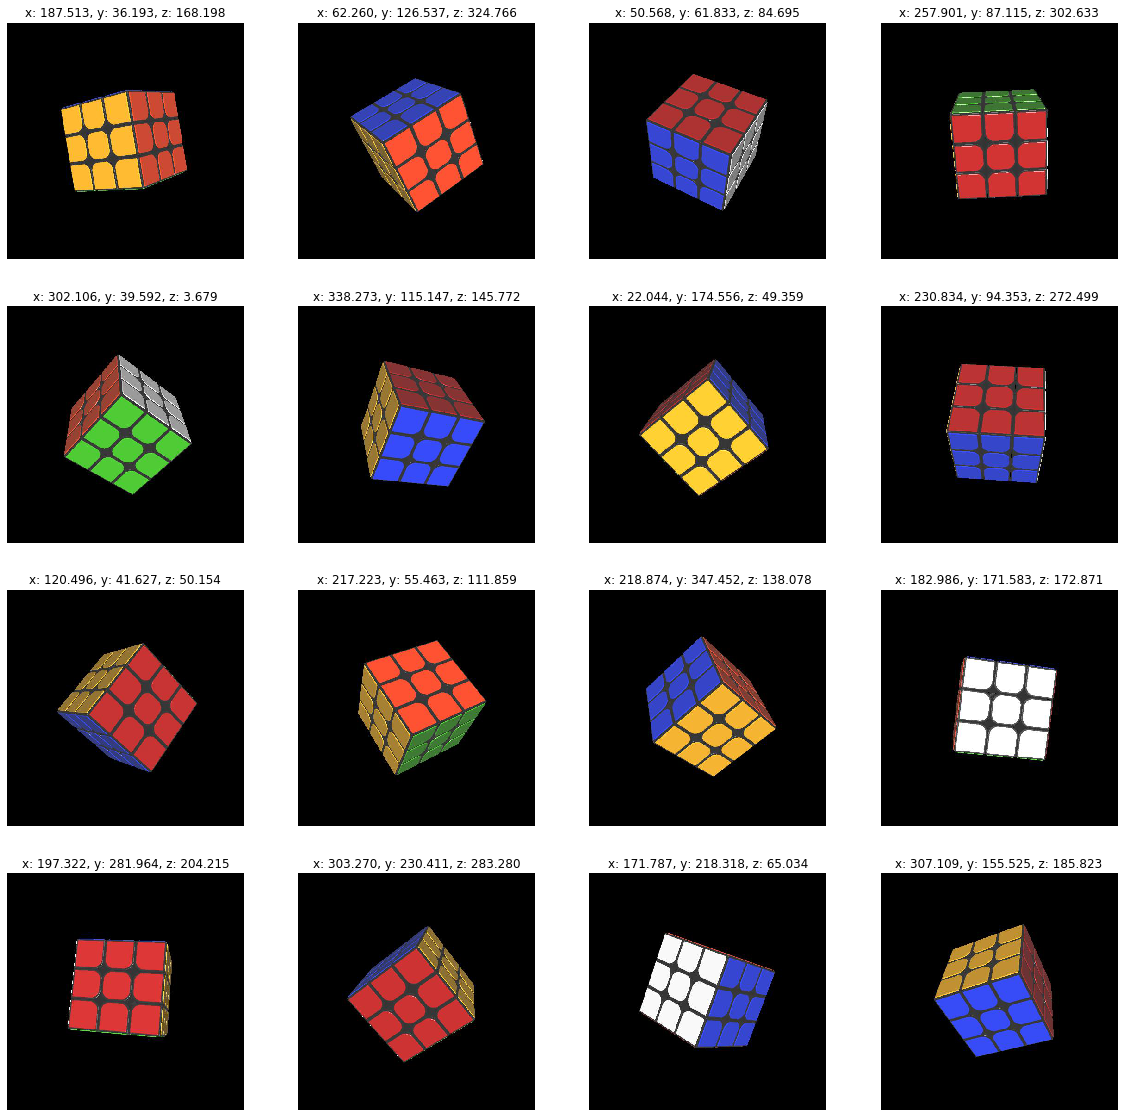

In [3]:
plt.figure(figsize=(20,20))
for i in range(16):
  path,x,y,z = train_data.labels_df.iloc[i]
  filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        path
    )
  im = Image.open(filepath)
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.title("x: %.3f, y: %.3f, z: %.3f"%(x,y,z))
  plt.imshow(im)

## Split Data into Train and Validation
We split the dataset into Training data and Validation datasets to help us test the generalizability of our models, and to ensure that we are not overfitting on the training set.

In [0]:
batch = 100
valid_size = 0.2
num = train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size = batch, sampler = valid_sampler)
test_loader = DataLoader(test_data, batch_size = batch, shuffle=False)

Here we have selected the size of the testing data to be 20% of the total data. You can change it and see what effect it has on the accuracies. To learn more about the train_test_split function [click here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Now, since we have our data splitted into train and validation sets, we need to get the label separated from the data.

## Define the Classifier
Now we finally come to the juicy part. 
Now that all the data is all loaded and available nice, we can finally get to training the classifier. Here we use sklearn [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) to train our network. We can tune the hyper parameters based on cross validation scores 

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

import torch.nn as nn
import torch.nn.functional as F


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False



class Net(nn.Module):
  # Define layers here
    def __init__(self, feature_extract=True):
        super(Net, self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)
        set_parameter_requires_grad(self.resnet, feature_extracting=feature_extract)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 6)


    def forward(self, x):
      # Forward pass
        return self.resnet(x)

feature_extract = True

model = Net(feature_extract).to(device)
error = nn.MSELoss().to(device)

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = optim.Adam(params_to_update)

## Train the classifier

In [0]:
n_epochs = 50
valid_loss_min = np.Inf

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    valid_loss_deg = 0.0
    
    model.train()
    for images in train_loader:
        data = images['gt'].squeeze(0).to(device)
        # data = data.squeeze(0)
        target = images['label'].to(device)
#             clear the gradients of all optimized variables
        optimizer.zero_grad()
#         forward pass the model
        output = model(data)
#     backward pass the model
        loss = error(output,target)
        loss.backward()
#         Perform a single optimization step
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    
    
    
    model.eval()
    for images in valid_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
#         forward pass now
        output = model(data)        
        loss = error(output, target)
        outputs_rot = trigs_to_angle(output)
        targets_rot = trigs_to_angle(target)
        valid_loss_deg += error(outputs_rot, targets_rot).item()*data.size(0)
#     update average validation loss
        valid_loss += loss.item()*data.size(0)

    train_loss /= len(train_loader.sampler)
    valid_loss /= len(valid_loader.sampler)
    valid_loss_deg /= len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Loss Deg: {:.6f}'.format(
        epoch, train_loss, valid_loss, valid_loss_deg))
    
    if valid_loss <= valid_loss_min:
        print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(valid_loss_min,valid_loss))
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'best_model_so_far.pth')

Iteration 1, loss = 16747.09323116
Iteration 2, loss = 6267.81371355
Iteration 3, loss = 5881.67650825
Iteration 4, loss = 5835.24373353
Iteration 5, loss = 5795.39806423
Iteration 6, loss = 5739.75166014
Iteration 7, loss = 5691.85701342
Iteration 8, loss = 5668.52422696
Iteration 9, loss = 5652.33722598
Iteration 10, loss = 5639.78673227
Iteration 11, loss = 5627.61985644
Iteration 12, loss = 5615.66774653
Iteration 13, loss = 5601.60722025
Iteration 14, loss = 5589.40557733
Iteration 15, loss = 5573.34865609
Iteration 16, loss = 5552.97766248
Iteration 17, loss = 5534.74783801
Iteration 18, loss = 5518.71086587
Iteration 19, loss = 5507.00724045
Iteration 20, loss = 5496.52598947
Iteration 21, loss = 5489.63235026
Iteration 22, loss = 5483.56160412
Iteration 23, loss = 5479.29583036
Iteration 24, loss = 5475.31918002
Iteration 25, loss = 5472.33014656
Iteration 26, loss = 5470.54825485
Iteration 27, loss = 5468.52853450
Iteration 28, loss = 5465.51588756
Iteration 29, loss = 5462.90

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=[10, 10], learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

## Predict on Validation
Now we predict our trained classifier on the validation set and evaluate our model

In [0]:
def trig_to_angle(xcos, xsin):
    if xcos >= 0:
        rot = 180*(torch.asin(xsin)) / math.pi
    else:
        rot = 180*(math.pi - torch.asin(xsin)) / math.pi
    
    return rot

def trigs_to_angle(out):
    ret = torch.zeros(out.shape[0], 3)
    for i, trig in enumerate(out):
        xcos, xsin = trig[0], trig[1]
        ycos, ysin = trig[2], trig[3]
        zcos, zsin = trig[4], trig[5]
        xRot = trig_to_angle(xcos, xsin)
        yRot = trig_to_angle(ycos, ysin)
        zRot = trig_to_angle(zcos, zsin)
        ret[i,0] = xRot
        ret[i,1] = yRot
        ret[i,2] = zRot 

    return ret


model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()
total_loss = 0
total_loss_deg = 0
with torch.no_grad():
    for images in valid_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model(data)
        outputs_rot = trigs_to_angle(outputs)
        targets_rot = trigs_to_angle(target)
        total_loss += error(output, target).item()*data.size(0)
        total_loss_deg += error(outputs_rot, targets_rot).item()*data.size(0)

print('Loss of the network on the 10000 test images: %f %f%%' % (
    total_loss, total_loss_deg))

## Evaluate the Performance
We use the same metrics as that will be used for the test set.  
[MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) and [RMSE](https://www.statisticshowto.com/rmse/) are the metrics for this challenge

In [0]:
#print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))  
#print('Mean Squared Error:', mean_squared_error(y_val, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))

Mean Absolute Error: 90.37427639406944
Mean Squared Error: 10872.550637486334
Root Mean Squared Error: 104.27152361736321


## Load Test Set
Load the test data now

## Make predictions on the test set

In [0]:
model.load_state_dict(torch.load('best_model_so_far.pth'))
model.eval()
total_loss = 0
test_predictions = []
with torch.no_grad():
    for images in test_loader:
        data = images['gt'].squeeze(0).to(device)
        target = images['label'].to(device)
        outputs = model(data)
        outs = outputs.detach().cpu().numpy()
        for i in outs:
            test_predictions.append(i)
        total_loss += error(output, target).item()*data.size(0)

print('Loss of the network on the 10000 test images: %f %%' % (
    total_loss))

In [0]:
test_df = pd.DataFrame(test_predictions, columns=['xRot', 'yRot', 'zRot'])
test_df["filename"] = TEST_FILENAMES

## Save the prediction to csv

In [0]:
test_df.to_csv('submission.csv', index=False)

Note: Do take a look at the submission format.The submission file should contain a header.